In [127]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator 
from scipy.signal import correlate
from statsmodels.tsa.stattools import adfuller, pacf, acf
from scipy.stats import shapiro, probplot, norm # shapiro wilk test for normality sample size thousands or fewer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

# Import Data

In [128]:


def importdata(key, path ,parseCol, From="2004-01-01", To="2019-09-01"):
    ''' 
    make sure the end date of the parse is shared between all datasets
    '''
    dataset = pd.read_csv("%s" %(path), index_col="%s" %(parseCol), parse_dates=["%s" %(parseCol)])
    if From==None and To==None:
        pass
    elif From and To:
        dataset = dataset.loc[From:To]
    return dataset


# import_PATH = r"\\ad.ucl.ac.uk\home0\zcecss0\DesktopSettings\Desktop\Research project\Data"    
import_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python - Projects\Research Project\Data"
save_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python - Projects\Research Project\Plots_Main"

meta = {# dataset: [path, Date_col, Value_col]
        "Google":[f"{import_PATH}\multiTimeline.csv", "Month", "Top5"], 
#        "RDPI":  [f"{import_PATH}\RealDisposableIncome-2004-1_Present-Mon-US(Grab-30-11-18).csv", "DATE", "DSPIC96"], 
#        "CPI":   [f"{import_PATH}\CPI.csv", "DATE", "CPI"],
#        "GDP":   [f"{import_PATH}\GDP.csv", "DATE", "GDP"], 
#        "UE":    [f"{import_PATH}\Unemployment_2004_Present_US(Grab-5-12-18).csv", "DATE", "Value"], 
        "SP500": [f"{import_PATH}\S&P500.csv", "Date", "Close"], 
#        "IR":    [f"{import_PATH}\InterestRate_2004-1-1_Present_US(Grab-5-12-18).csv", "DATE", "FEDFUNDS"], 
#        "PPI":   [f"{import_PATH}\PPIACO.csv", "DATE", "PPI"],
#        "PMI":   [f"{import_PATH}\ISM-MAN_PMI.csv", "Date", "PMI"],
        "DJI":   [f"{import_PATH}\DJI.csv", "Date", "Close"]} 

data ={}
for key in meta.keys():
    data[key] = importdata(key, meta[key][0], meta[key][1])

# Visualise Data

In [ ]:

minor_locator = AutoMinorLocator(12)
for key in data.keys():
    fig, ax1 = plt.subplots()
    data[key][meta[key][2]].plot(ax=ax1,color='k').xaxis.set_minor_locator(minor_locator)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(key, color='k')
    plt.grid()
    Title = f"{key}"
#     ax2 = ax1.twinx()
#     data[key2][array2].plot(ax=ax2,color='r')
#     ax2.set_ylabel(array2, color='r')
#     ax2.tick_params('y', colors='r')
    plt.title(Title)
#    plt.savefig("%s\%s.png" %(save_PATH, Title))

1. Google data is limited to the dates ["2004-01-01":"2019-09-01"]
2. data undergoes structural break from 2008 to 2009 so model is best to be fit from 2009 onwards
3. train data is to be 95% of available data after parse

In [129]:
SP = data["SP500"]["Close"].loc["2009-01-01":"2018-12-01"]
DJI= data["DJI"]["Close"].loc["2009-01-01":"2018-12-01"]
GGL = data["Google"][meta["Google"][2]].loc["2009-01-01":"2018-12-01"]

# Data evaluation

1. Is variance constant over time? 
- Plot yearly variance (or growth rate), If growth present take logarithm
2. Is there seasonality?
- plot month's data over the years in box plot to compare seasonality
3. Is data stationary? 
- If ADF test, If no difference until stationary


#### Seasonality

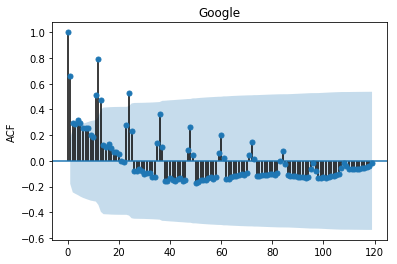

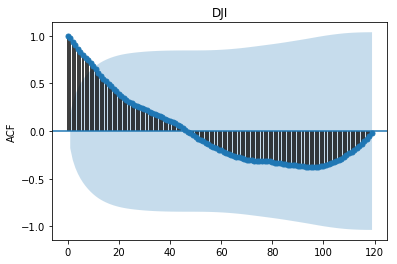

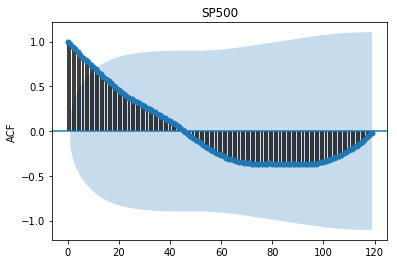

In [130]:
def acf_pacf(data, Title):
    fig, axes = plt.subplots(1,1)
    plot_acf(data, ax=axes, title=f"{Title}")
    axes.set(ylabel="ACF")
    
acf_pacf(GGL, "Google");
acf_pacf(DJI, "DJI");
acf_pacf(SP, "SP500");


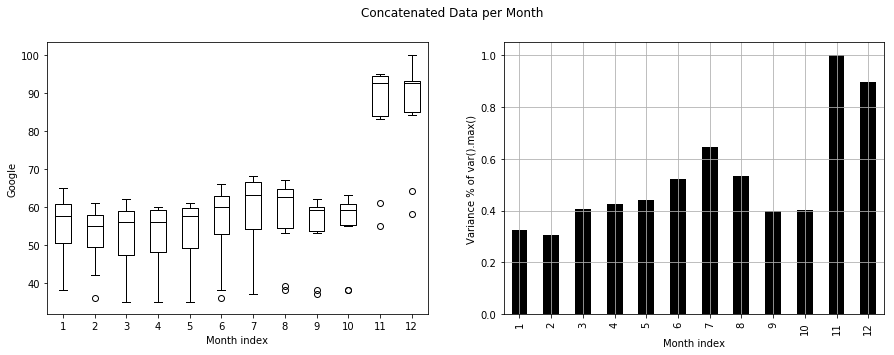

In [131]:
def seasonality_check(DF, Title, key=None, array=None, ):
    """
    data must not include incomplete years. 
    """
    if key and array: #check this line later
        df = data[key][array]
    else:
        df = DF
    mm = [M for M in range(1,13)]
    df_by_month = {}
    for M in mm:
        val = []
        for year in range(len(df)//12):
            val.append(df.iloc[year*12+M-1])
        df_by_month[M] = val
    df_by_month = pd.DataFrame.from_dict(df_by_month)    
    
    fig, axes = plt.subplots(1,2, figsize=(15,5))   
    fig.suptitle("Concatenated Data per Month")
    df_by_month.plot(ax=axes[0], kind="box" , color="k")
    (df_by_month.var()/df_by_month.var().max()).plot(ax=axes[1], kind="bar", grid=True, color="k") # is this normalisation correct?
    axes[0].set(ylabel=f"{Title}", xlabel="Month index")
    axes[1].set(xlabel="Month index", ylabel="Variance % of var().max()")
    return df_by_month


# DJI_by_month = seasonality_check(DJI, "DJI")
# SP_by_month = seasonality_check(SP, "SP500")
GGL_by_month = seasonality_check(GGL, "Google")

$\rightarrow$ seasonal trend seen

# Differencing




## Google

In [132]:
def ADF(array):
    ''' check for unit root errors in dataset'''
    result = adfuller(array)
    print('ADF t-Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] >= 0.05:
        rej = False
    else:
        rej = True
    print("reject H_0:", rej)
    
GGL_log = np.log(GGL)
GGL_log_trend = GGL_log.diff(12).dropna()
GGL_log_diff = GGL_log_trend.diff(1).dropna()
# GGL_seasonal_diff = GGL.diff(12).dropna()
# GGL_diff = GGL.diff(12).diff(1).dropna()


ADF(GGL_log_trend)
ADF(GGL_log_diff)

ADF t-Statistic: -1.663237
p-value: 0.450146
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
reject H_0: False
ADF t-Statistic: -4.775102
p-value: 0.000061
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584
reject H_0: True



$\rightarrow$ seasonal D=1 

$\rightarrow$ trend d=1

# ywunbiased why doesnt it work?

While using the Yule-Walker method, the underlying assumptions of stationarity must be met and therefore, the data must be detrended, transformed (Box-Cox) and/or differenced if needed. Also, accordign to Enders 2014 \[XXX\] given a sample size of T, it is suggested to consider T/4 lags of the PACF. 


Enders, W., 2004. Applied econometric time series /Walter Enders. 2nd ed., Hoboken, NJ]: J. Wiley.

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


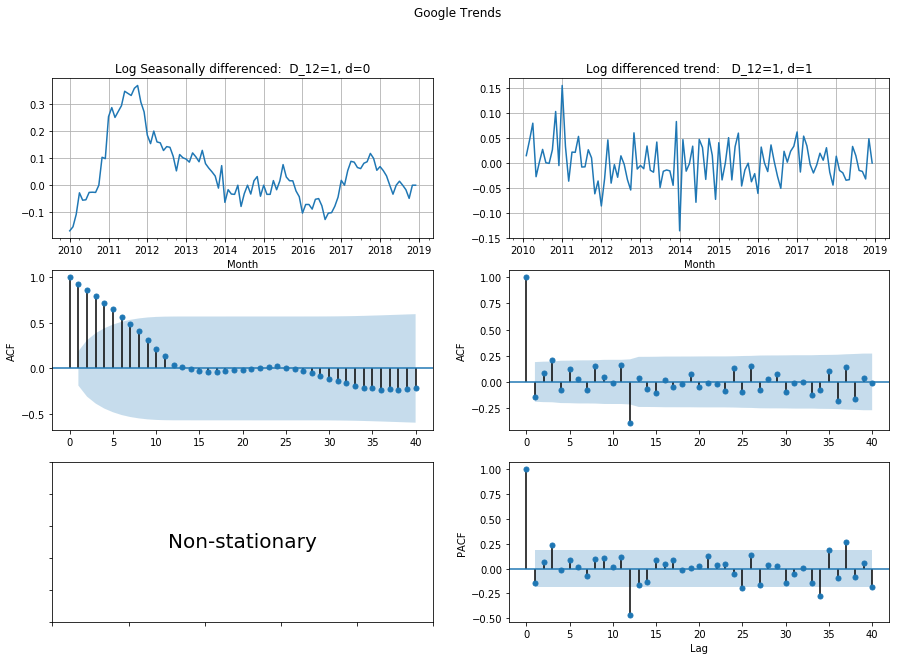

In [133]:
def diff_plots(diff1, diff2, Title="", Title1="Log Seasonally differenced:  D_12=1, d=0", Title2="Log differenced trend:   D_12=1, d=1", lag=40, txt=True, savefig=False):
    fig, axes = plt.subplots(3,2, figsize=[15,10])
    fig.suptitle(Title)
    diff1.plot(ax=axes[0,0], grid=True, title=Title1)
    plot_acf(diff1, ax=axes[1,0], title="", lags=lag);
    axes[1,0].set(ylabel="ACF")
    temp = pacf(GGL_log_diff, nlags=100).max()
    # following doesnt work
    if temp <= 1 and txt==False:
        plot_pacf(diff1, method="ywunbiased", ax=axes[2,0], title="", lags=lag);
        axes[2,0].set(ylabel="PACF", xlabel="Lag")
    elif txt==True:
        axes[2,0].text(.5,.5,"Non-stationary",horizontalalignment='center', verticalalignment='center', fontsize=20)
        axes[2, 0].xaxis.set_ticklabels([])
        axes[2, 0].yaxis.set_ticklabels([])
    else:
        pass
    
    diff2.plot(ax=axes[0,1], grid=True, title=Title2)
    plot_acf(diff2, ax=axes[1,1], title="", lags=lag);
    axes[1,1].set(ylabel="ACF")
    plot_pacf(diff2, method="ywunbiased", ax=axes[2,1], title="", lags=lag);
    axes[2,1].set(ylabel="PACF", xlabel="Lag")
    
    if savefig==True:
        fig.savefig("%s\%s.png" %(save_PATH, Title))
    else: pass

diff_plots(GGL_log_trend, GGL_log_diff, Title="Google Trends")



$\rightarrow$ Start with  $GGL = ARIMA(6,2,1)(12,1,1)_{12}$


## SP500

In [134]:
def coolplot(data, supTitle, Title="", pacfmethod="ywunbiased", savefig=False):
    fig = plt.figure(figsize=[15,10])
    fig.suptitle(supTitle)
    grid = plt.GridSpec(3,2,wspace=0.3, hspace=0.4)
    
    ax1 = plt.subplot(grid[0,0])
    data.plot(ax=ax1, grid=True)
    ax1.set(title=Title)
    plt.hlines(y=data.mean(), xmin="2009-01-01", xmax="2018-12-01", color="r")
    
    ax2 = plt.subplot(grid[1,0])
    plot_acf(data, ax=ax2, lags=40)
    ax2.set(ylabel="ACF", xlabel="Lag")
    
    ax3 = plt.subplot(grid[1,1])
    plot_pacf(data, ax=ax3, method=pacfmethod, lags=40)
    ax3.set(ylabel="PACF", xlabel="Lag")
    
    ax4 = plt.subplot(grid[0,1])
    (data**2).plot(title=f"{Title} squared returns", grid=True, ax=ax4)
    
    ax5 = plt.subplot(grid[2,0])
    data.plot(kind="hist", ax=ax5)
#     x = np.linspace(data.min(), data.max(),num=100)
#     plt.plot(x, norm.pdf(x, 1, np.sqrt(1)),color="r")

    
    ax6 = plt.subplot(grid[2,1])
    probplot(data, plot=ax6, rvalue=True)
    ax6.set(title="QQ plot")
    ax6.grid()
    
    stat, p = shapiro(data)
    if p >= 0.05:
        print(" \t %s Normally distributed" %(supTitle))
    else:
        print(" \t %s Not normally distributed" %(supTitle))
        
    print("\n \t Shapiro t-Statistics: %.3f \n \t p-value: %.3f" %(stat, p))

    
    if savefig==True:
        fig.savefig("%s\%s.png" %(save_PATH, Title))
    else: pass
    

ADF t-Statistic: -11.898261
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
reject H_0: True
 	 SP500 Not normally distributed

 	 Shapiro t-Statistics: 0.974 
 	 p-value: 0.022
ADF t-Statistic: -5.327099
p-value: 0.000005
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
reject H_0: True
 	 SP500 Not normally distributed

 	 Shapiro t-Statistics: 0.966 
 	 p-value: 0.004


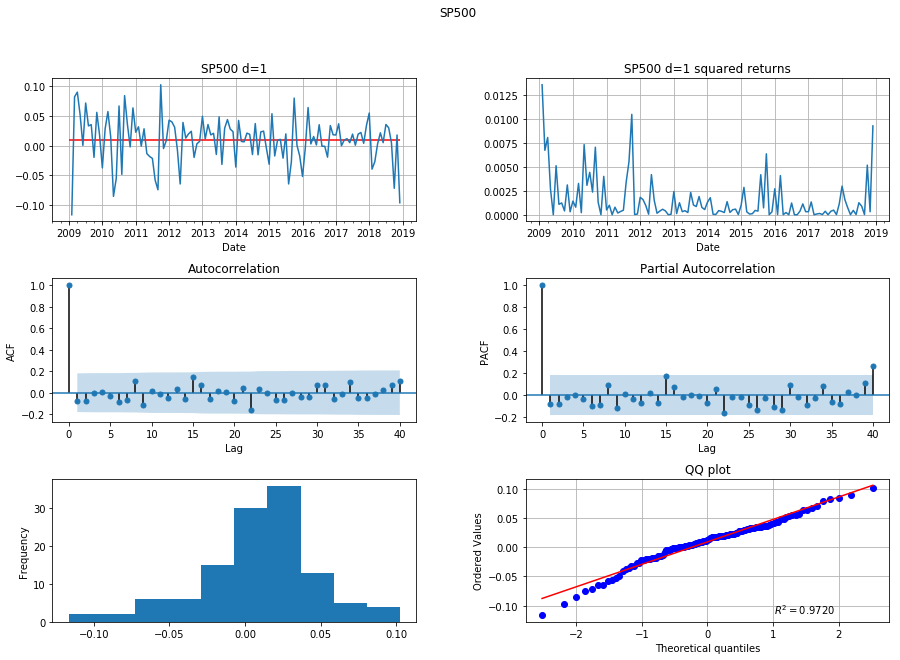

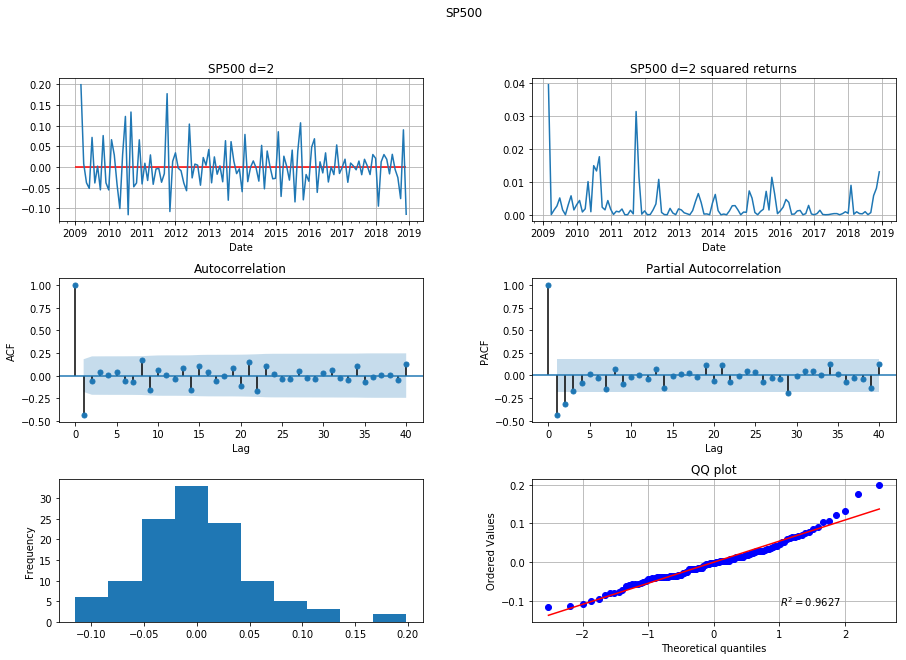

In [135]:
SP_log_diff = np.log(SP).diff(1).dropna()
ADF(SP_log_diff)
coolplot(SP_log_diff, Title="SP500 d=1", supTitle="SP500")

SP_log_diff2 = SP_log_diff.diff(1).dropna()
ADF(SP_log_diff2)
coolplot(SP_log_diff2, Title="SP500 d=2", supTitle="SP500", savefig=True)

$\rightarrow SP = ARIMA(3,2,1)$

first differencing gives error type 1 on ADF

# DJI

In [ ]:
DJI_log_diff = np.log(DJI).diff(1).dropna()
ADF(DJI_log_diff)
coolplot(DJI_log_diff, "DJI d=1")

DJI_log_diff2 = DJI_log_diff.diff(1).dropna()
ADF(DJI_log_diff2)
coolplot(DJI_log_diff2, "DJI d=2", savefig=True)

$\rightarrow DJI = ARIMA(3,2,1)$

# SARIMA(p,d,q)(P,D,Q)$_m$

90% of the data is chosen as a training set and the remainder can be used as an in sample test of the fit.

In [136]:
def test_train(data):
    train, test = np.log(data.iloc[:round(len(data)*0.95)]), np.log(data.iloc[round(len(data)*0.9):])
    return train, test

GGL_train, GGL_test = test_train(GGL)[0], test_train(GGL)[1]
SP_train, SP_test = test_train(SP)[0], test_train(SP)[1]
DJI_train, DJI_test = test_train(DJI)[0], test_train(DJI)[1]

## Google

In [137]:
GGL_model = SARIMAX(GGL, order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
GGL_fit = GGL_model.fit(disp=False)

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## SP500

# SP500 needs to be differenced twice or else SARIMAX gives non-stationarity error! but why does the ADF reject null?

In [138]:
SP_model = SARIMAX(SP_train, trend='c', order=(1,1,1))
SP_fit = SP_model.fit(disp=False)

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## DJI

In [ ]:
DJI_model = SARIMAX(DJI_train, trend='c', order=(1,1,1))
DJI_fit = DJI_model.fit(disp=False)

# AIC, BIC, optimisation

Here we also check to see if there is overfitting etc (in sample forecast)

In [139]:
# HQIC_list = SP_info.iloc[2]
# print(f"{} minimised at: \n",HQIC_list[HQIC_list==HQIC_list.min()])

def optimise_SARIMAX(data, maxpdq, maxPDQ=(0,0,0,0)):
    ''' iterates through p and q and outputs best AIC, BIC, HQIC order fits'''
    tests = ["AIC", "BIC", "HQIC"]
    results = {}

    for p in range(1,maxpdq[0]+1):
        for q in range(1,maxpdq[2]+1):
            if sum(maxPDQ) != 0:
                for P in range(1, maxPDQ[0]+1):
                    for Q in range(1, maxPDQ[2]+1):
                        pdqorder=(p,maxpdq[1],q)
                        PDQOrder = (P, maxPDQ[1], Q, maxPDQ[3])
                        order_Order=(pdqorder,PDQOrder)
                        print(f" order: {order_Order}")
                        mod_fit = SARIMAX(data, order=(p,maxpdq[1],q), seasonal_order=(P,maxPDQ[1],Q,maxPDQ[3]),enforce_invertibility=False).fit()
                        AIC = mod_fit.aic
                        BIC = mod_fit.bic
                        HQIC = mod_fit.hqic
                        results[order_Order] = (AIC,BIC,HQIC)                        
            else:
                pdqorder = (p,maxpdq[1],q)
                print(f"order: {pdqorder}")
                mod_fit = SARIMAX(data, order=pdqorder).fit()
                AIC = mod_fit.aic
                BIC = mod_fit.bic
                HQIC = mod_fit.hqic
                results[pdqorder] = (AIC,BIC,HQIC)
    results = pd.DataFrame(results, index=tests).T
    print("\n")
# choose minimum
    for i in range(len(tests)):
        print(f"{tests[i]} minimised at: \n", results[tests[i]][results[tests[i]]==results[tests[i]].min()])
    return results

In [140]:
SP_fit_tests = optimise_SARIMAX(SP_train, maxpdq=(4,2,2))
SP_fit_tests

order: (1, 2, 1)
order: (1, 2, 2)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (2, 2, 2)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (3, 2, 2)
order: (4, 2, 1)


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


order: (4, 2, 2)


AIC minimised at: 
 2  2  1   -409.012868
Name: AIC, dtype: float64
BIC minimised at: 
 1  2  1   -400.760289
Name: BIC, dtype: float64
HQIC minimised at: 
 1  2  1   -405.606842
Name: HQIC, dtype: float64


AIC         BIC        HQIC
1 2 1 -408.915786 -400.760289 -405.606842
    2 -406.328201 -395.454206 -401.916275
2 2 1 -409.012868 -398.138873 -404.600942
    2 -405.497535 -391.905041 -399.982628
3 2 1 -406.943688 -393.351194 -401.428781
    2 -405.102154 -388.791161 -398.484266
4 2 1 -404.859220 -388.548227 -398.241331
    2 -403.097109 -384.067617 -395.376239

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


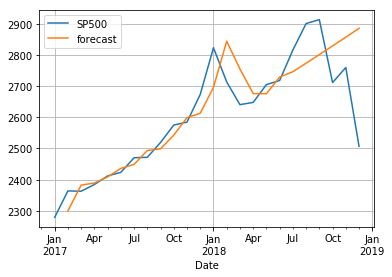

In [197]:
SP_model_fit = SARIMAX(SP_train, order=(1,2,1)).fit()
SP_SARIMAX_forecast = SP_model_fit.predict(start="2017-02-01", end="2018-12-01")

fig, axes = plt.subplots()
SP.loc["2017-01-01":].plot(ax=axes, label="SP500")
np.exp(SP_SARIMAX_forecast).plot(ax=axes, label="forecast")
axes.legend()
axes.grid()

In [203]:
SP_SARIMAX_forecast.keys()


DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

[Text(0,0.5,'ACF')]

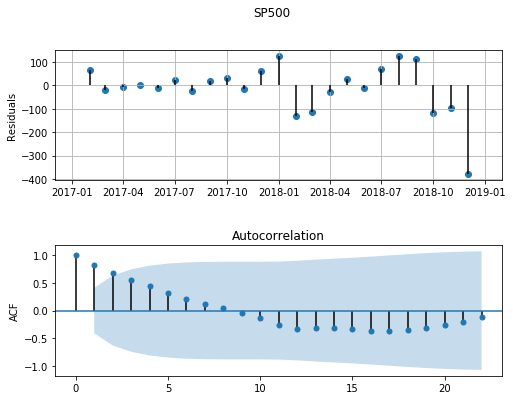

In [208]:
fig = plt.figure(figsize=[8,6])
plt.suptitle("SP500")
grid = plt.GridSpec(2,1,wspace=0.3, hspace=0.5)
ax = [None, None]
ax[0] = plt.subplot(grid[0,0])
ax[0].set(ylabel="Residuals")
ax[0].grid()
xs = SP_SARIMAX_forecast.keys()
ax[0].scatter(xs,SP.loc["2017-02-01":"2018-12-01"]-np.exp(SP_SARIMAX_forecast))
ax[0].vlines(xs, 0, SP.loc["2017-02-01":"2018-12-01"]-np.exp(SP_SARIMAX_forecast))

ax[1] = plt.subplot(grid[1,0])
plot_acf(SP_SARIMAX_forecast, ax=ax[1]);
ax[1].set(ylabel="ACF")


In [ ]:
DJI_fit_tests = optimise_SARIMAX(DJI_train, maxpdq=(4,2,2))
DJI_fit_tests

In [ ]:
DJI_model_fit = SARIMAX(SP_train, order=(2,2,1)).fit()
DJI_SARIMAX_forecast = DJI_model_fit.predict(start="2017-02-01", end="2018-12-01")

fig, axes = plt.subplots()
DJI_train.loc["2017-01-01":].plot(ax=axes, label="SP500")
np.exp(DJI_SARIMAX_forecast).plot(ax=axes, label="forecast")
axes.legend()
axes.grid()

In [ ]:
GGL_fit_tests = optimise_SARIMAX(GGL_train, maxpdq=(2,2,2), maxPDQ=(2,1,2,12))
GGL_fit_tests

# GARCH(p,q)

#### Heteroskedacticity

__WHY DOES THE LOG ADF GIVE STATIONARITY?__

due to heteroskedasticity, test hypotheses are no longer valid which is why the t-stat results in type 1 errors. Also, the OLS estimators are no longer BLUE (best linear unbiased estimators) which allows us to perform tests such as: 
- Levene test: instead of Bartlett Test because its less sensitive to normality
- Breusch Pagan Test: assumes errors are normally distributed 
- Score Test: assumes error terms are iid (independent identically distributed)
- F Test: iid assumed for errors

log transformation of the data is unnecessary because there is no overal growth rate and the inflation appears to be linear. Therefore, log transforming the data meerly changes the scale of it and not yield any significance. 


# __In this section, to make the variance comparable and a relatable metric, the variances were normalised by variance.max(). Is this correct?__

Berusch Pagan test:
$$\sigma_i = \sigma . f(\alpha_0 + \alpha z_i)$$
Homoscedasticity implies: $alpha=0$

In [ ]:
def var_growth_check(df):
    df_years = {}
    mm = [M for M in range(12)]
    for year in range(len(df)//12):
        val = []
        for M in mm:
            val.append(df.iloc[year*12+M])
        df_years[year] = val
    df_years = pd.DataFrame.from_dict(df_years)
    return df_years

DJI_year_var = var_growth_check(DJI)
SP_year_var = var_growth_check(SP)
GGL_year_var = var_growth_check(GGL)

fig, axes = plt.subplots(3,2,figsize=(15,12))
fig.suptitle("Yearly Variance Growth")
DJI.plot(ax=axes[0, 0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[0,0].set(ylabel="DJI", xlim=["2009-01-01" , "2018-12-01"])
(DJI_year_var.var()/DJI_year_var.var().max()).plot(ax=axes[0, 1],grid=True, color="k", kind="bar") # is this normalisationcorrect
axes[0, 1].set(xlabel="Year index", ylabel="var(DJI)")
# axes[0, 1].tick_params(labelbottom=False)

SP.plot(ax=axes[1, 0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[1,0].set(ylabel="SP500", xlim=["2009-01-01" , "2018-12-01"])
(SP_year_var.var()/SP_year_var.var().max()).plot(ax=axes[1, 1],grid=True, color="k", kind="bar")# is this normalisationcorrect
axes[1, 1].set(xlabel="Year index", ylabel="var(SP500)")
# axes[1, 1].tick_params(labelbottom=False)

GGL.plot(ax=axes[2,0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[2,0].set(ylabel="Google", xlim=["2009-01-01" , "2018-12-01"])
(GGL_year_var.var()/GGL_year_var.var().max()).plot(ax=axes[2,1], grid=True, color="k", kind="bar")
axes[2, 1].set(xlabel="Year index", ylabel="var(GGL)")
# axes[2, 1].tick_params(labelbottom=False)

# plt.savefig()


# Levene test (null says equal variance) cant use because data is not normal
# from scipy.stats import levene

# which function to use in the test
# ‘median’ : Recommended for skewed (non-normal) distributions>
# ‘mean’ : Recommended for symmetric, moderate-tailed distributions.
# ‘trimmed’ : Recommended for heavy-tailed distributions.
# def lev(data):
#     Levene = levene(data[len(data)//2:], data[:len(data//2)], center="trimmed")
#     print("Levene Test:")
#     print("\tstatistic=", Levene[0])
#     print("\tp-value=", Levene[1])
#     # with alpha = 0.05, if F>1.9855 regect null (sigma_1=sigma_2=...=sigma_p)
#     if Levene[1] <= 0.5:
#         rej = True
#     else:
#         rej = False
#     print("reject H_0:", rej)
    
# lev(GGL.diff(1).dropna())
# lev(SP.diff(1).dropna())
# lev(DJI.diff(1).dropna())

#Breusch Pagan Test
# from statsmodels.stats.diagnostic import het_breuschpagan
# from statsmodels.formula.api import ols



#Score Test

# F-test


# Residual analysis

# Break points

breaks_cusumolsresid
cusum test for parameter stability based on ols residuals
breaks_hansen
test for model stability, breaks in parameters for ols, Hansen 1992
recursive_olsresiduals
Calculate recursive ols with residuals and cusum test statistic. This is currently mainly helper function for recursive residual based tests. However, since it uses recursive updating and doesn’t estimate separate problems it should be also quite efficient as expanding OLS function.


https://en.wikipedia.org/wiki/Structural_break


# Crosscorrelation

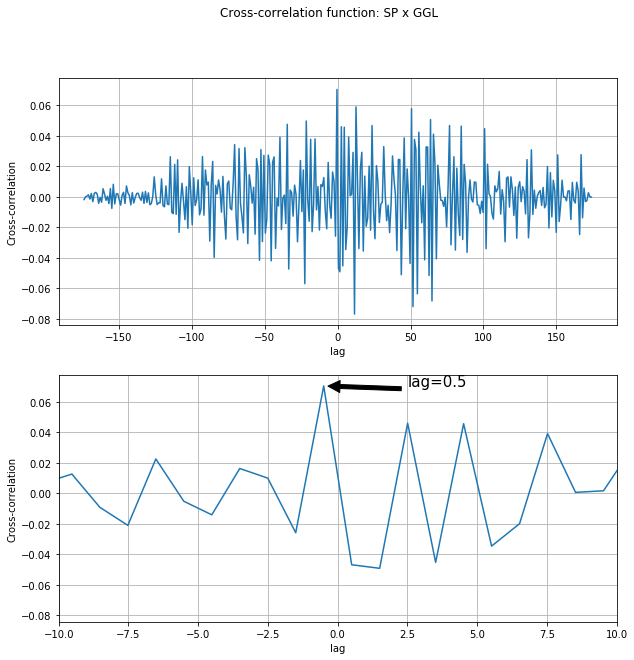

In [209]:
GGLdiff2 = np.log(data["Google"]["Top5"]).diff(12).diff(1).dropna()
SPdiff2 = np.log(data["SP500"]["Close"]).diff(1).diff(1).dropna()

def xcorr(data1, data2):
    '''method:
    r_xy = (sum((x_i - x.mean)(y_i-y.mean)))/(sqrt(sum((x_i - x.mean)**2)sum((y_i-y.mean)**2)))
    '''
    ys = correlate(data1, data2, method="direct")
    xs = np.linspace(0-len(ys)//2, 0+len(ys)//2, len(ys))
    fig, ax = plt.subplots(2,1,figsize=[10,10])
    fig.suptitle("Cross-correlation function: SP x GGL")
    ax[1].plot(xs,ys)
    ax[1].grid()
    ax[1].set(ylabel="Cross-correlation", xlabel="lag",xlim=[-10,10])
    ax[1].annotate("lag=0.5", xy=(-0.5,ys.max()), xytext=(2.5,ys.max()),fontsize=15,arrowprops=dict(facecolor='black', shrink=0.05))
    ax[0].plot(xs,ys)
    ax[0].grid()
    ax[0].set(ylabel="Cross-correlation", xlabel="lag")

xcorr(SPdiff2, GGLdiff2)

# VAR and ARDL

for VAR assume no co-linearity/co-integration

In [211]:
def optimise_VARMAX(data, maxpq):
    ''' iterates through p and q and outputs best AIC, BIC, HQIC order fits'''
    tests = ["AIC", "BIC", "HQIC"]
    results = {}

    for p in range(1,maxpq[0]+1):
        for q in range(1,maxpq[1]+1):
            pqorder = (p,q)
#             print(f"order: {pqorder}")
            mod_fit = VARMAX(data, order=pqorder, maxiter=200, method="powel").fit()
            AIC = mod_fit.aic
            BIC = mod_fit.bic
            HQIC = mod_fit.hqic
            results[pqorder] = (AIC,BIC,HQIC)
    results = pd.DataFrame(results, index=tests).T
    print("\n")
# choose minimum
    for i in range(len(tests)):
        print(f"{tests[i]} minimised at: \n", results[tests[i]][results[tests[i]]==results[tests[i]].min()])
    return results

In [213]:
for shifts in range(-1,1):
    print("shift:",shifts)
    VARset = pd.DataFrame()
    VARset["SP"] = SP_log_diff2
    VARset["GGLshifted"] = GGL_log_diff.shift(shifts).dropna()
    optimise_VARMAX(VARset, maxpq=(3,3))

shift: -1


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferre



AIC minimised at: 
 1  2   -778.280714
Name: AIC, dtype: float64
BIC minimised at: 
 1  1   -738.719167
Name: BIC, dtype: float64
HQIC minimised at: 
 1  1   -760.113332
Name: HQIC, dtype: float64
shift: 0


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferre



AIC minimised at: 
 1  1   -783.738428
Name: AIC, dtype: float64
BIC minimised at: 
 1  1   -747.719528
Name: BIC, dtype: float64
HQIC minimised at: 
 1  1   -769.113693
Name: HQIC, dtype: float64


C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Even though the cross correlation showed that google has a half a step predictability, this would only be useful if we had more data points at higher frequency. As seen from the above iterations, all test results show an improvement when the google data is not shifted.

shift | AIC | BIC
------|----|----
-4| 776| 740 <br>
-3| 780| 742 <br>
-2| 779| 737 <br>
-1| 778| 738 <br>
$\rightarrow$__0__| __783__| __747__ <br>
1| 780| 744 <br>
2| 776| 740 <br>
3| 772| 736 <br>
4| 770| 733 <br>

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


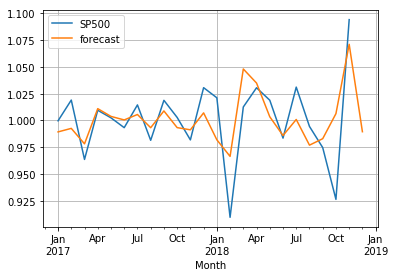

In [214]:
var_model11 = VARMAX(VAR_GGL_SP, order=(1,1)).fit(disp=False)
# print(var_model_fit.summary())
SP_VAR_forecast = var_model11.predict(start="2017-01-01", end="2018-12-01")

def forecastplot(data1,forecasts):
    fig, axes = plt.subplots()
    data1.loc["2017-01-01":].plot(ax=axes, label="SP500")
    forecasts.plot(ax=axes, label="forecast")
    axes.legend()
    axes.grid()

forecastplot(np.exp(VAR_GGL_SP["SP"]),np.exp(SP_VAR_forecast["SP"]))

# var_model32 = VARMAX(VAR_GGL_SP, order=(3,2)).fit(disp=False)
# SP_VAR_forecast2 = var_model32.predict(start="2017-01-01", end="2018-12-01")

# forecastplot(VAR_GGL_SP["SP"],SP_VAR_forecast2["SP"])


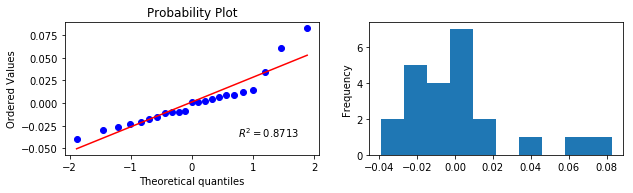

In [259]:
plt.figure(figsize=[10,10])
grid=plt.GridSpec(3,2, hspace=0.55)

ax=plt.subplot(grid[0,:])
ys = SP_VAR_forecast["SP"].iloc[:-1]-VAR_GGL_SP["SP"]
xs = VAR_GGL_SP["SP"].keys()
ax1.scatter(xs,ys)
ax1.vlines(xs,0,ys)
ax1.grid()
ax1.set(ylabel="residuals")
plt.xticks(rotation="vertical")

ax2= plt.subplot(grid[1:])
plot_acf(ys.dropna(), ax=ax2);
ax1.set(ylabel="ACF")

ax3= plt.subplot(grid[2,0])
probplot(ys.dropna(), plot=ax3, rvalue=True)

ax4= plt.subplot(grid[2,1])
ys.dropna().plot(kind="hist", ax=ax4)

# Forecast horizon 

# Forecasting (KMC)

# Test reference
http://www.statsmodels.org/stable/diagnostic.html?highlight=heteroscedasticity


# Remarks

The analysis does not show causality 
